In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from matplotlib import pyplot as plt 
import cv2 as cv
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
import torchvision 
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader, SubsetRandomSampler,random_split
from PIL import Image
from torchvision.models import vgg19
from transformers import ViTConfig, ViTModel
import math

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
path_folder_img = "/kaggle/input/gps-drone-3/drone1_image"
path_img = "/kaggle/input/gps-drone-3/drone1_image/1.jpg"
image = Image.open(path_img)
image = transform(image)
image = image.unsqueeze(0) 
image = image.to(device)
image.size()

torch.Size([1, 3, 224, 224])

In [6]:
configuration = ViTConfig()
model = ViTModel(configuration)
x = torch.rand((1, 3, 224, 224))
out = model(x)
print(out)
print(out['pooler_output'].size())

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.1695, -0.0715, -0.6904,  ..., -1.2296,  0.4109, -0.2920],
         [-0.5131,  0.2287, -1.8189,  ..., -1.1726,  0.3775,  0.1097],
         [-0.8606,  0.3945, -1.5057,  ..., -0.8740,  0.8114, -0.1438],
         ...,
         [-0.3947,  0.5910, -1.7844,  ..., -1.3879,  0.6453,  0.0518],
         [-0.7674,  0.7203, -1.9038,  ..., -1.4847,  0.2720, -0.1612],
         [-0.5368,  0.1471, -1.7448,  ..., -0.6476,  0.3465,  0.2320]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 1.5132e-01,  4.8603e-01,  2.1279e-01, -5.7786e-02, -6.9891e-01,
          7.1695e-01, -2.5667e-01, -8.0757e-01,  2.4248e-01,  5.0085e-01,
         -7.0746e-01,  1.3134e-01, -2.8080e-01,  5.1963e-02,  3.9414e-01,
         -5.6311e-01,  8.7117e-01,  4.1533e-02, -8.4713e-01, -6.6046e-01,
          6.7693e-02,  1.1517e-01,  6.2357e-01, -4.6162e-01, -8.4669e-02,
          9.5929e-01,  2.2763e-01, -8.7739e-01,  3.4550e-01,  5.2751e-02,
         -2

In [7]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fcnn = ViTModel(configuration)
        self.fc1 = nn.Linear(774, 1024)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(128, 64)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc6 = nn.Linear(64, 2)

    def forward(self,img,x):
        img = self.fcnn(img)['pooler_output']
        x = x.view(x.size(0),-1)
        x = torch.cat((img,x),dim=1)
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
        return out

# Read CSV

In [8]:
path_csv = "/kaggle/input/gps-drone-3/data_train_3.csv"
data = pd.read_csv(path_csv)

In [9]:
data.columns

Index(['filename', 'lat', 'lon', 'altitude', 'roll', 'yaw', 'pitch', 'x', 'y',
       'GPS_lat', 'GPS_lon', 'distance_point', 'bearing_point', 'id',
       'E_shift', 'N_shift'],
      dtype='object')

/tmp/ipykernel_32/2997349075.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


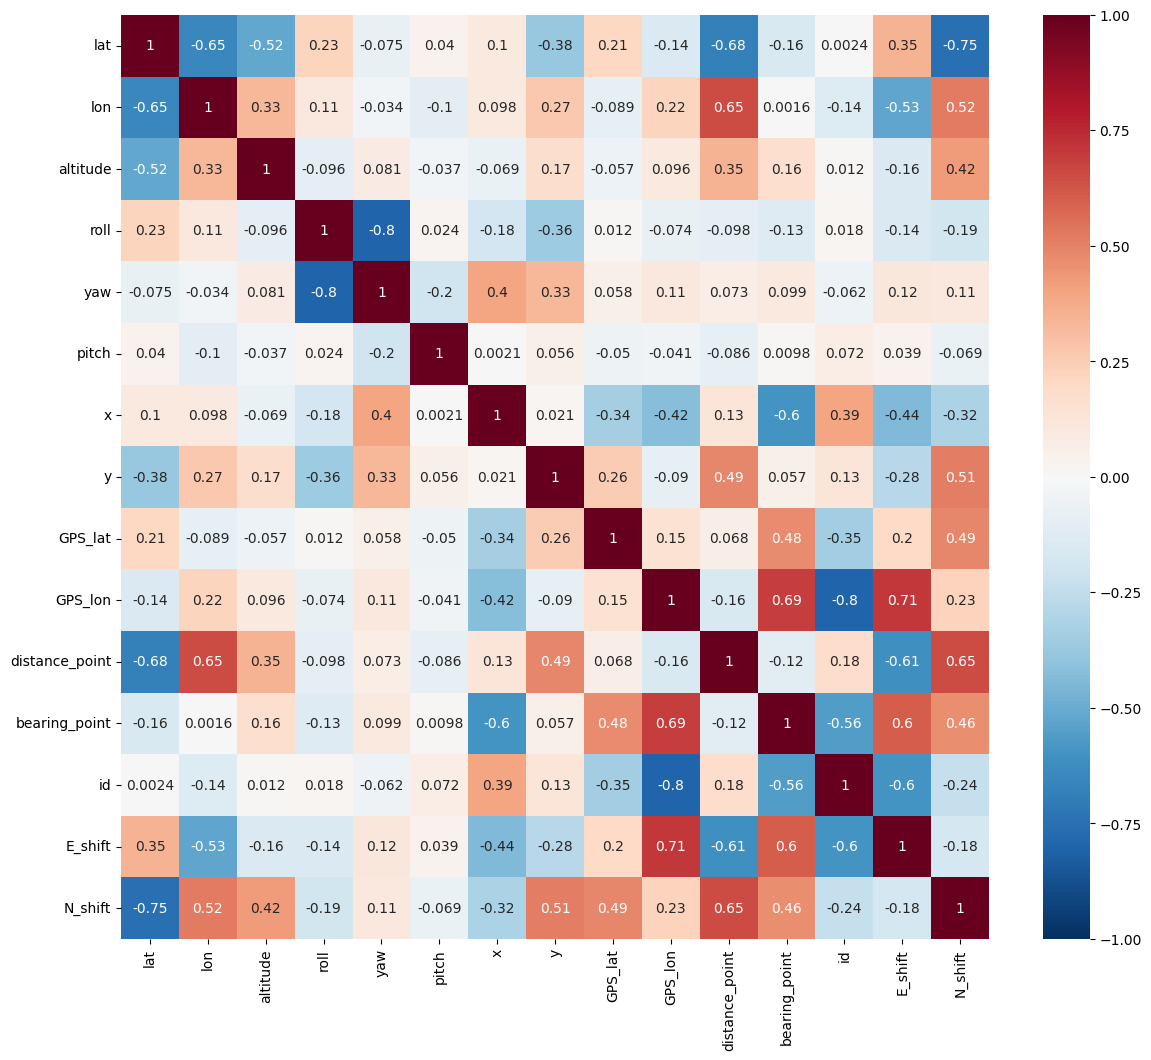

In [10]:
correlation = data.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

In [11]:
nn_model = NeuralNet()
nn_model = nn_model.to(device)


In [12]:
nn_model.eval()

NeuralNet(
  (fcnn): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_feature

In [13]:
images = torch.rand((1, 3, 224, 224)).to(device)
x = torch.rand((1, 6)).to(device)
output = nn_model(images, x)


In [14]:
class CustomDataset(Dataset):
      def __init__(self,csv_file,transform = None):
        self.data = pd.read_csv(csv_file)
        self.transform =  transform
      def __getitem__(self,index):
        path = path_folder_img+"/"+self.data.iloc[index,0]
        image = Image.open(path)
        if self.transform is not None:
            image = self.transform(image)
        data = self.data.iloc[index, 3:9].values.astype('float32')
        label = self.data.iloc[index, 9:11].values.astype('float32')
        return image,torch.from_numpy(data),torch.from_numpy(label)
      def __len__(self):
        return len(self.data)
      

In [15]:
dataset = CustomDataset(path_csv,transform)
train_size = int(0.8 * len(dataset))
testval_size = len(dataset) - train_size
train_dataset, testval_dataset = random_split(dataset, [train_size, testval_size])

val_size = int(0.5 * len(testval_dataset))
test_size = len(testval_dataset) - val_size
val_dataset, test_dataset = random_split(testval_dataset, [val_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [16]:
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)


In [17]:
def RMSE(y_pred,y_true):
    loss = torch.mean(torch.square(y_pred - y_true))
    rmse = torch.sqrt(loss)
    return rmse


In [ ]:
nn_model.train()
num_epochs = 1000
val =[]
train = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, datax in enumerate(train_dataloader,0):
        images, data, labels = datax
        images =images.to(device)
        data = data.to(device)
        labels = labels.to(device)
        outputs = nn_model(images,data)
        loss = RMSE(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()/len(train_dataset)
    train.append(running_loss)
    val_loss = 0.0
    with torch.no_grad():
        for j,inputs in enumerate(val_dataloader,0):
            images, data, labels = inputs
            images = images.to(device)
            data = data.to(device)
            labels = labels.to(device)
            outputs = nn_model(images,data)
            loss = RMSE(outputs, labels)
            val_loss += loss.item()/len(val_dataset)
        val.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Train loss: {running_loss:.4f}, Val loss: {val_loss:.4f}")

Epoch 1/1000: Train loss: 1.3737, Val loss: 0.2124
Epoch 2/1000: Train loss: 0.9643, Val loss: 0.2536
Epoch 3/1000: Train loss: 0.9354, Val loss: 0.2179
Epoch 4/1000: Train loss: 0.8796, Val loss: 0.2078
Epoch 5/1000: Train loss: 0.8735, Val loss: 0.2366
Epoch 6/1000: Train loss: 0.8337, Val loss: 0.2836
Epoch 7/1000: Train loss: 0.8050, Val loss: 0.1851


In [ ]:
nn_model.eval()